In [1]:
import os

In [2]:
BASE_DIR = os.path.dirname(os.getcwd())
BASE_DIR

'c:\\Users\\PC\\Desktop\\UIT\\TU_CHON_TU_DO\\CS406_XU_LY_ANH_VA_UNG_DUNG\\image-classification'

In [3]:
TEST_DIR = os.path.join(BASE_DIR, "dataset", "test")
TEST_DIR

'c:\\Users\\PC\\Desktop\\UIT\\TU_CHON_TU_DO\\CS406_XU_LY_ANH_VA_UNG_DUNG\\image-classification\\dataset\\test'

In [4]:
CHECKPOINT_DIR = os.path.join(BASE_DIR, "checkpoints")
CHECKPOINT_DIR

'c:\\Users\\PC\\Desktop\\UIT\\TU_CHON_TU_DO\\CS406_XU_LY_ANH_VA_UNG_DUNG\\image-classification\\checkpoints'

In [5]:
from train_and_save import PREPROCESSOR

MODELS = [
    "EfficientNetB5",
    "DenseNet121",
    "ResNet50V2",
    "MobileNetV2",
]

c:\Users\PC\Desktop\UIT\TU_CHON_TU_DO\CS406_XU_LY_ANH_VA_UNG_DUNG\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import tensorflow as tf

In [7]:
def create_datasets(preprocess_fn, test_dir, BATCH_SIZE=32, IMG_SIZE=(224, 224), SEED=24520152):
    """
    Create Tensorflow datasets for testing

    Args:
        preprocess_fn (callable): The preprocessing function specific to the model (e.g., tf.keras.applications.efficientnet.preprocess_input)
        test_dir (str): Path to the testing image directory
        BATCH_SIZE (int): Batch size
        IMG_SIZE (tuple): Target image size
        SEED (int): Random seed for reproducibility

    Returns:
        val_ds (tf.data.Dataset): Preprocessed testing dataset
    """
    val_ds = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        shuffle=False,
        seed=SEED,
    )

    AUTOTUNE = tf.data.AUTOTUNE

    def preprocess_val(image, label):
        """Apply preprocessing to the validation set (no augmentation)"""
        image = preprocess_fn(image)
        return image, label

    val_ds = val_ds.cache().map(preprocess_val, num_parallel_calls=AUTOTUNE).prefetch(buffer_size=AUTOTUNE)

    return val_ds

In [8]:
results = []

for model_name in MODELS:
    print(f"\nEvaluating {model_name}")
    best_model_path = os.path.join(CHECKPOINT_DIR, f"{model_name}_best.keras")
    if os.path.exists(best_model_path):
        model = tf.keras.models.load_model(best_model_path)
    else:
        raise FileNotFoundError(f"Not found {model_name} at {best_model_path}")

    preprocess_fn = PREPROCESSOR[model_name]
    test_ds = create_datasets(preprocess_fn=preprocess_fn, test_dir=TEST_DIR)

    loss, acc = model.evaluate(test_ds, verbose=1)
    results.append({
        "Model": model_name,
        "Loss": loss,
        "Accuracy": acc,
    })


Evaluating EfficientNetB5
Found 3000 files belonging to 6 classes.
94/94 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.9197 - loss: 0.2232

Evaluating DenseNet121
Found 3000 files belonging to 6 classes.
94/94 ━━━━━━━━━━━━━━━━━━━━ 96s 911ms/step - accuracy: 0.9027 - loss: 0.2484

Evaluating ResNet50V2
Found 3000 files belonging to 6 classes.
94/94 ━━━━━━━━━━━━━━━━━━━━ 69s 696ms/step - accuracy: 0.9090 - loss: 0.2358

Evaluating MobileNetV2
Found 3000 files belonging to 6 classes.
94/94 ━━━━━━━━━━━━━━━━━━━━ 27s 252ms/step - accuracy: 0.9083 - loss: 0.2456


In [10]:
import pandas as pd

In [11]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("Accuracy", ascending=False).reset_index(drop=True)
results_df.style.background_gradient(cmap="Blues", subset="Accuracy")

,Model,Loss,Accuracy
0,EfficientNetB5,0.223234,0.919667
1,ResNet50V2,0.235836,0.909000
2,MobileNetV2,0.245562,0.908333
3,DenseNet121,0.248365,0.902667


In [12]:
best_model = results_df.iloc[0]["Model"]
best_acc = results_df.iloc[0]["Accuracy"]

In [13]:
f"Best model: {best_model} with validation accuracy = {best_acc:.4f}"

'Best model: EfficientNetB5 with validation accuracy = 0.9197'

In [15]:
import numpy as np

In [16]:
model = tf.keras.models.load_model(os.path.join(CHECKPOINT_DIR, f"{best_model}_best.keras"))
preprocess_fn = PREPROCESSOR[best_model]
test_ds = create_datasets(preprocess_fn=preprocess_fn, test_dir=TEST_DIR)

y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_pred = np.argmax(model.predict(test_ds), axis=1)

Found 3000 files belonging to 6 classes.
94/94 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step


In [20]:
from sklearn.metrics import classification_report

In [26]:
all_items = os.listdir(TEST_DIR)
all_items

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [27]:
class_labels = sorted([item for item in all_items if os.path.isdir(os.path.join(TEST_DIR, item))])
class_labels

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [28]:
print(classification_report(y_true, y_pred, target_names=class_labels))

              precision    recall  f1-score   support

   buildings       0.96      0.92      0.94       437
      forest       0.99      0.99      0.99       474
     glacier       0.90      0.78      0.84       553
    mountain       0.82      0.90      0.86       525
         sea       0.95      0.98      0.97       510
      street       0.93      0.97      0.95       501

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000



In [29]:
from sklearn.metrics import confusion_matrix

In [30]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[400,   1,   0,   1,   1,  34],
       [  0, 470,   0,   2,   0,   2],
       [  1,   2, 431, 101,  16,   2],
       [  0,   3,  40, 472,   9,   1],
       [  0,   0,   7,   2, 501,   0],
       [ 16,   0,   0,   0,   0, 485]])

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

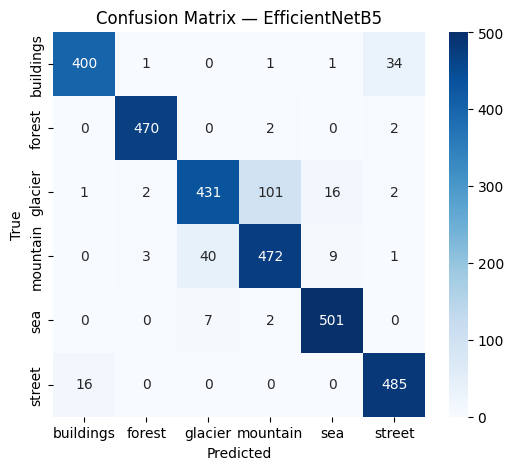

In [36]:
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title(f"Confusion Matrix — {best_model}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()